In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "/home/carlo/bristoluni/Applied Data Science/git-master/Data/"
filename = path + "water_quality.csv"

In [2]:
# fits the scatter points with many polynomial degrees minimizing the squared error, which is reported.
# the length of the 'colors' array determines the number of polynomial degrees to try
def fit_scatter_and_plot(var_x, var_y, xs, ys, unit_x, unit_y, colors):
    for c, degree in zip(colors, range(1, len(colors) + 1, 1)):
        coefficients, least_squared_error, _, _, _ = np.polyfit(xs, ys, degree, full=True)
        plt.plot(np.unique(xs), np.poly1d(coefficients)(np.unique(xs)), c, label='deg %d, SE = %.2f' % (degree, least_squared_error))
    plt.scatter(xs, ys)
    plt.xlabel(var_x + ' ' + unit_x)
    plt.ylabel(var_y + ' ' + unit_y)
    plt.title(var_x + ' and ' + var_y)
    plt.legend(loc='upper right')

In [3]:
# further process of the data frame
def split_on_variables_then_merge_data_frames_on_keys(frame, keys, var1, var2):
    selected_rows = frame[(frame['determinand.label'] == var1) | (frame['determinand.label'] == var2)]
    left_frame = selected_rows[selected_rows['determinand.label'] == var1]
    right_frame = selected_rows[selected_rows['determinand.label'] == var2]
    merged = pd.merge(left_frame, right_frame, on=keys)
    return merged

In [4]:
data = pd.read_csv(filename)
df = data[['determinand.label', 'result', 'determinand.unit.label', 'water body']]

grouped = df.groupby(['determinand.label', 'determinand.unit.label'])['result'].agg([pd.np.min, pd.np.max, pd.np.mean, pd.np.std, 'count'])
filtered = grouped[grouped['count'] > 15]
#del filtered['count']

In [5]:
filtered

,,amin,amax,mean,std,count
determinand.label,determinand.unit.label,,,,,
Alky pH 4.5,mg/l,171.00000,326.0000,234.973684,32.325613,38
Ammonia(N),mg/l,0.03000,9.1700,0.577450,1.457473,60
B-[a]-pyrene,ug/l,0.00017,0.0229,0.002287,0.005085,20
B-[b]-fluora,ug/l,0.00037,0.0241,0.002732,0.005269,20
B-[ghi]-pery,ug/l,0.00036,0.0313,0.003066,0.006888,20
B-[k]-fluora,ug/l,0.00011,0.0111,0.001155,0.002443,20
BOD ATU,mg/l,8.00000,464.0000,92.280000,164.836414,25
COD as O2,mg/l,52.00000,1255.0000,394.625000,496.830068,16
Cond @ 25C,us/cm,538.00000,2557.0000,903.552632,403.940302,38


In [6]:
# process data frame, select columns of interest.
df2 = data[['determinand.label', 'result', 'determinand.unit.label', 'sample.sampleDateTime', 'Waterbody ID']]

In [7]:
# find correlation between variables
# 1-2, 2-3, 3-4, ...
variable1 = 'Ammonia(N)'
variable2 = 'N Oxidised'
variable3 = 'Nitrate-N'
variable4 = 'Nitrite-N'
variable5 = 'Orthophospht'
variable6 = 'pH'
variable7 = 'Temp Water'

In [8]:
# create a left and right data frame (to separate the variables) and then do an inner join 
# on the water body and date.
# (i.e. pick the measurements that were taken at the same time and place)
keys = ['Waterbody ID', 'sample.sampleDateTime']
merged_df = split_on_variables_then_merge_data_frames_on_keys(frame=df2, keys=keys, var1=variable1, var2=variable2)

# get the ingredients to produce the plot
xs, ys = merged_df['result_x'], merged_df['result_y']
var_x, var_y = merged_df['determinand.label_x'][0], merged_df['determinand.label_y'][0]
unit_measure_x, unit_measure_y = merged_df['determinand.unit.label_x'][0], merged_df['determinand.unit.label_y'][0]

In [9]:
# TO DO
# 1. fit curve/ polynomial and display it in the graph (we may try different degrees)
# 2. report squared error
# 3. if the relation is linear, computer Pearson index coefficient. Otherwise, I don't know
# 4. talk about the relation

In [10]:
# 1. fit scatter points minimizing the squared error (SE).
colors = ['r', 'g', 'b']
plt.figure(0)
fit_scatter_and_plot(var_x=var_x, var_y=var_y, xs=xs, ys=ys, unit_x=unit_measure_x, unit_y=unit_measure_y, colors=colors)

In [11]:
# correlation between variable 2 and 3
merged_df = split_on_variables_then_merge_data_frames_on_keys(frame=df2, keys=keys, var1=variable2, var2=variable3)

# get the ingredients to produce the plot
xs, ys = merged_df['result_x'], merged_df['result_y']
var_x, var_y = merged_df['determinand.label_x'][0], merged_df['determinand.label_y'][0]
unit_measure_x, unit_measure_y = merged_df['determinand.unit.label_x'][0], merged_df['determinand.unit.label_y'][0]
plt.figure(1)
fit_scatter_and_plot(var_x=var_x, var_y=var_y, xs=xs, ys=ys, unit_x=unit_measure_x, unit_y=unit_measure_y, colors=colors)

In [12]:
# correlation between variable 3 and 4
merged_df = split_on_variables_then_merge_data_frames_on_keys(frame=df2, keys=keys, var1=variable3, var2=variable4)

# get the ingredients to produce the plot
xs, ys = merged_df['result_x'], merged_df['result_y']
var_x, var_y = merged_df['determinand.label_x'][0], merged_df['determinand.label_y'][0]
unit_measure_x, unit_measure_y = merged_df['determinand.unit.label_x'][0], merged_df['determinand.unit.label_y'][0]
plt.figure(2)
fit_scatter_and_plot(var_x=var_x, var_y=var_y, xs=xs, ys=ys, unit_x=unit_measure_x, unit_y=unit_measure_y, colors=colors)

In [13]:
# correlation between variable 4 and 5
merged_df = split_on_variables_then_merge_data_frames_on_keys(frame=df2, keys=keys, var1=variable4, var2=variable5)

# get the ingredients to produce the plot
xs, ys = merged_df['result_x'], merged_df['result_y']
var_x, var_y = merged_df['determinand.label_x'][0], merged_df['determinand.label_y'][0]
unit_measure_x, unit_measure_y = merged_df['determinand.unit.label_x'][0], merged_df['determinand.unit.label_y'][0]
plt.figure(3)
fit_scatter_and_plot(var_x=var_x, var_y=var_y, xs=xs, ys=ys, unit_x=unit_measure_x, unit_y=unit_measure_y, colors=colors)

In [14]:
# correlation between variable 5 and 6
merged_df = split_on_variables_then_merge_data_frames_on_keys(frame=df2, keys=keys, var1=variable5, var2=variable6)

# get the ingredients to produce the plot
xs, ys = merged_df['result_x'], merged_df['result_y']
var_x, var_y = merged_df['determinand.label_x'][0], merged_df['determinand.label_y'][0]
unit_measure_x, unit_measure_y = merged_df['determinand.unit.label_x'][0], merged_df['determinand.unit.label_y'][0]
plt.figure(4)
fit_scatter_and_plot(var_x=var_x, var_y=var_y, xs=xs, ys=ys, unit_x=unit_measure_x, unit_y=unit_measure_y, colors=colors)

In [15]:
# correlation between variable 6 and 7
merged_df = split_on_variables_then_merge_data_frames_on_keys(frame=df2, keys=keys, var1=variable6, var2=variable7)

# get the ingredients to produce the plot
xs, ys = merged_df['result_x'], merged_df['result_y']
var_x, var_y = merged_df['determinand.label_x'][0], merged_df['determinand.label_y'][0]
unit_measure_x, unit_measure_y = merged_df['determinand.unit.label_x'][0], merged_df['determinand.unit.label_y'][0]
plt.figure(5)
fit_scatter_and_plot(var_x=var_x, var_y=var_y, xs=xs, ys=ys, unit_x=unit_measure_x, unit_y=unit_measure_y, colors=colors)

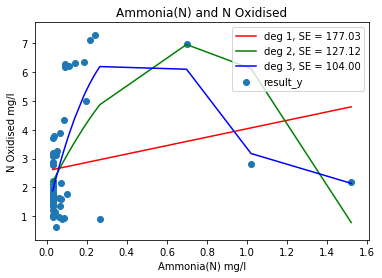

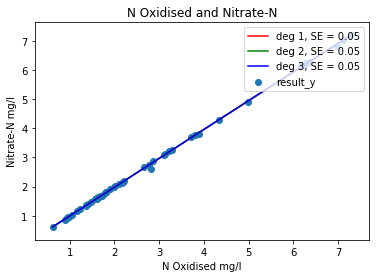

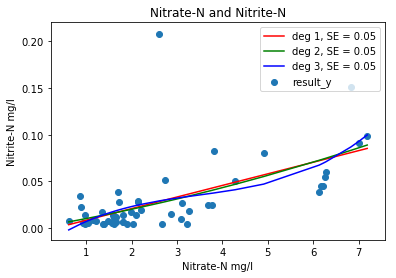

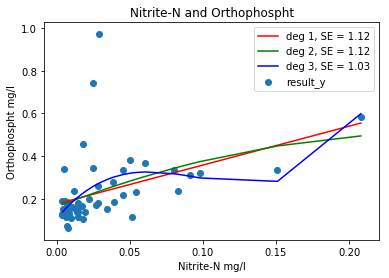

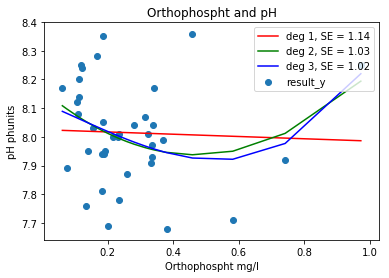

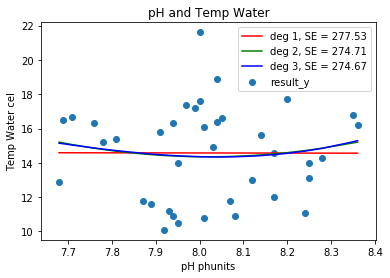

In [16]:
plt.show()